In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
import matplotlib.pylab as plt
from matplotlib.pylab import rcParams
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acf, pacf
from sklearn.metrics import r2_score
rcParams['figure.figsize'] = 15, 6
%matplotlib inline

# 1.

In [ ]:
# Считывание данных

In [2]:
def dateparse(dates):
    lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
    return dates

In [4]:
data1 = pd.read_csv('training.csv', parse_dates=['Date'], index_col='Date', date_parser=dateparse)
data2 = pd.read_csv('testing.csv', parse_dates=['Date'], index_col='Date', date_parser=dateparse)
print(data1.head())
print(data2.head())

              Value
Date               
1959-01-01  22.8331
1959-02-01  23.2802
1959-03-01  23.6156
1959-04-01  24.1186
1959-05-01  24.4820
              Value
Date               
1989-01-01  64.6158
1989-02-01  64.3268
1989-03-01  64.4548
1989-04-01  64.5270
1989-05-01  64.0662


In [7]:
ts = data1['Value']

In [ ]:
# График для training

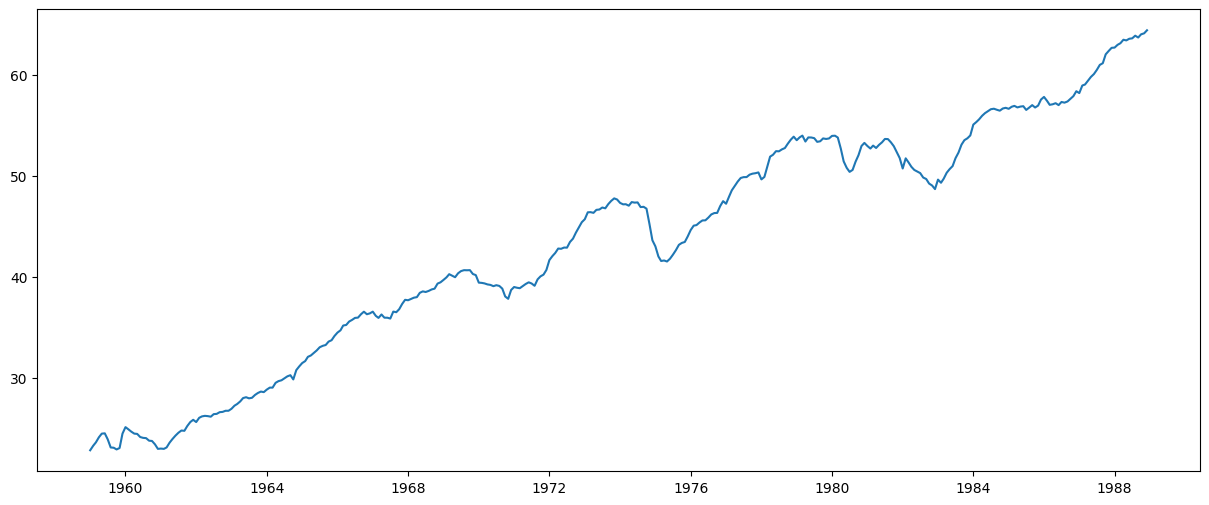

In [8]:
plt.plot(ts)

In [ ]:
# Функция для проверки ряда на стационарность
# с помощью теста Дики-Фуллера, попутно визуализируя

In [9]:
def test_stationarity(timeseries):
    # Определяем скользящее среднее
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    # Тест Дики - Фуллера:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4],
                         index=['Test Statistic', 'p-value',
                                '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)
    if dftest[0] > dftest[4]['5%']:
        print('NO')
        return 'NO'
    else:
        print('YES')
        return 'YES'

In [ ]:
# Проверка на стационарность training

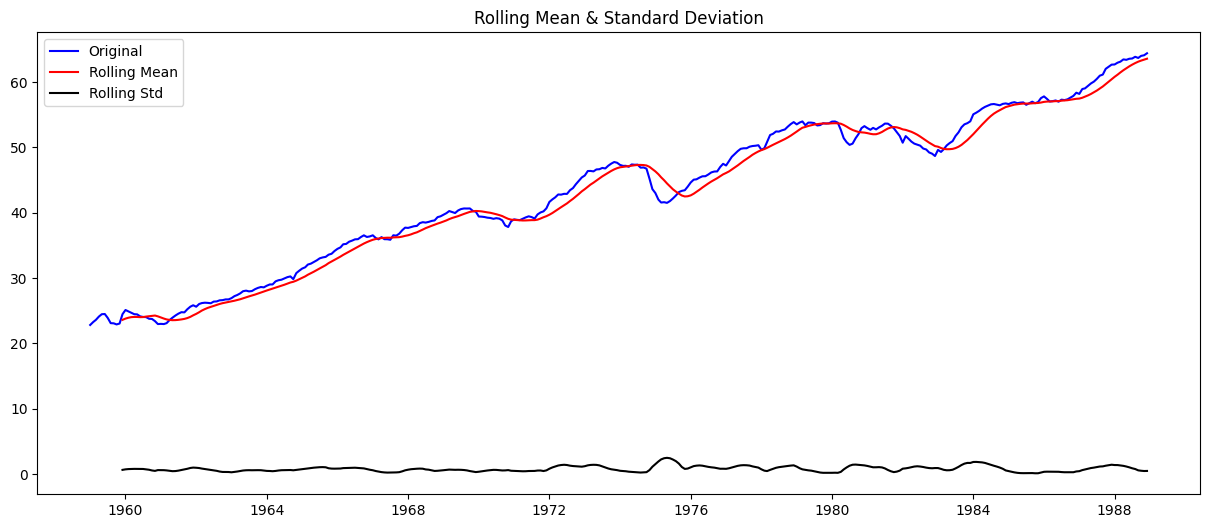

Results of Dickey-Fuller Test:
Test Statistic                  -0.253391
p-value                          0.931851
#Lags Used                       5.000000
Number of Observations Used    354.000000
Critical Value (1%)             -3.448958
Critical Value (5%)             -2.869739
Critical Value (10%)            -2.571138
dtype: float64
NO


'NO'

In [10]:
test_stationarity(ts)

In [ ]:
# вывод: проведя тест Дики-Фуллера, видим,
# что временной ряд нестационарный в широком смысле. Также на графике можно
# увидеть график нашего ряда, график средней статистики
# и стандартного отклонения.

# 2.

In [ ]:
# Разложение ряда на тренд, сезональность и остаток

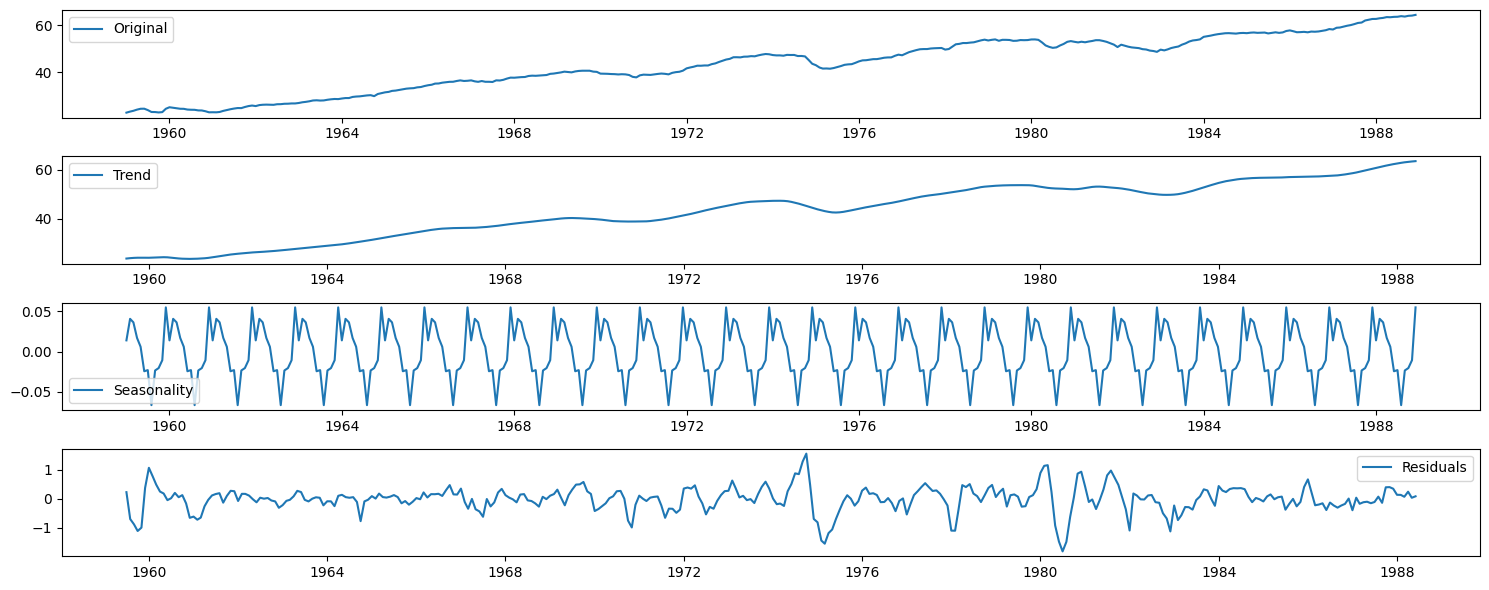

In [12]:
decomposition = seasonal_decompose(ts)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts, label='Original')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(seasonal, label='Seasonality')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')

plt.tight_layout()

In [ ]:
# Проверка на стационарность тренда

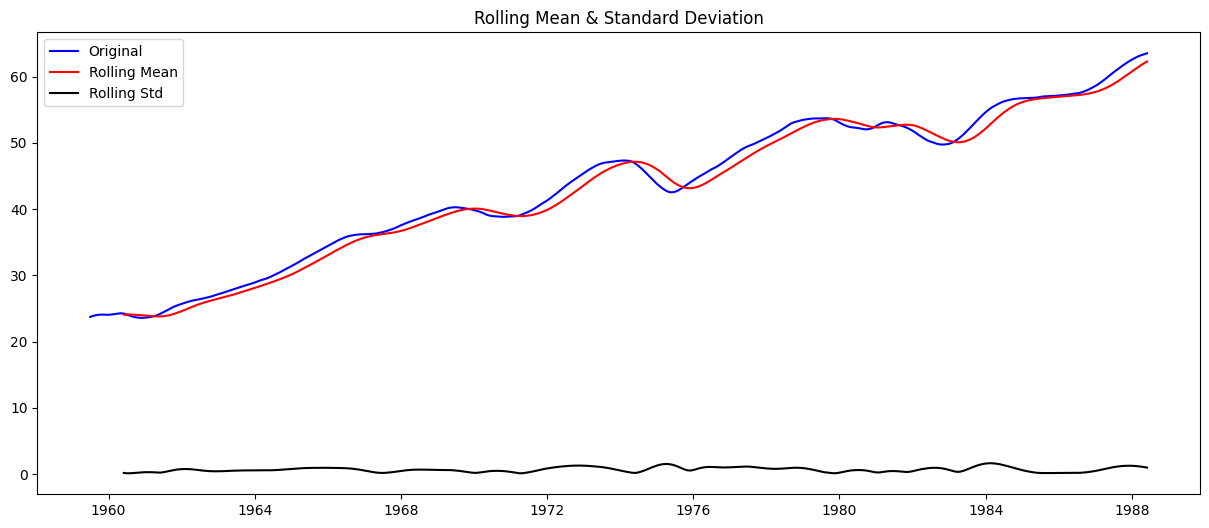

Results of Dickey-Fuller Test:
Test Statistic                  -0.861576
p-value                          0.800363
#Lags Used                      17.000000
Number of Observations Used    330.000000
Critical Value (1%)             -3.450322
Critical Value (5%)             -2.870338
Critical Value (10%)            -2.571458
dtype: float64
NO


'NO'

In [13]:
ts_t = trend
ts_t.dropna(inplace=True)
test_stationarity(ts_t)

In [ ]:
# Проверка на стационарность сезональность

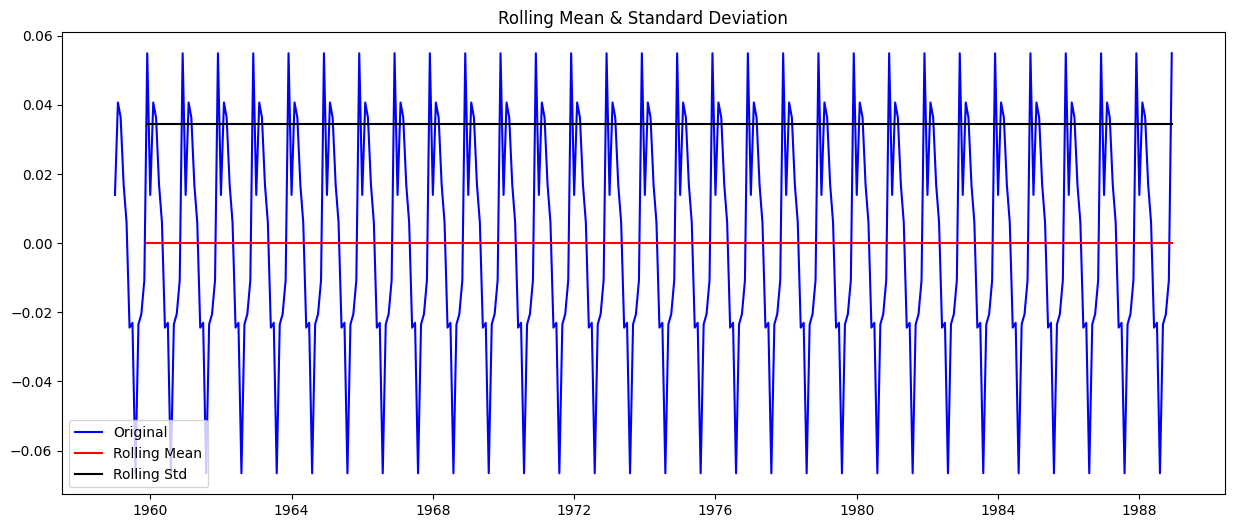

Results of Dickey-Fuller Test:
Test Statistic                -5.403896e+14
p-value                        0.000000e+00
#Lags Used                     1.100000e+01
Number of Observations Used    3.480000e+02
Critical Value (1%)           -3.449282e+00
Critical Value (5%)           -2.869881e+00
Critical Value (10%)          -2.571214e+00
dtype: float64
YES


'YES'

In [14]:
ts_s = seasonal
ts_s.dropna(inplace=True)
test_stationarity(ts_s)

In [ ]:
# Проверка на стационарность остаток

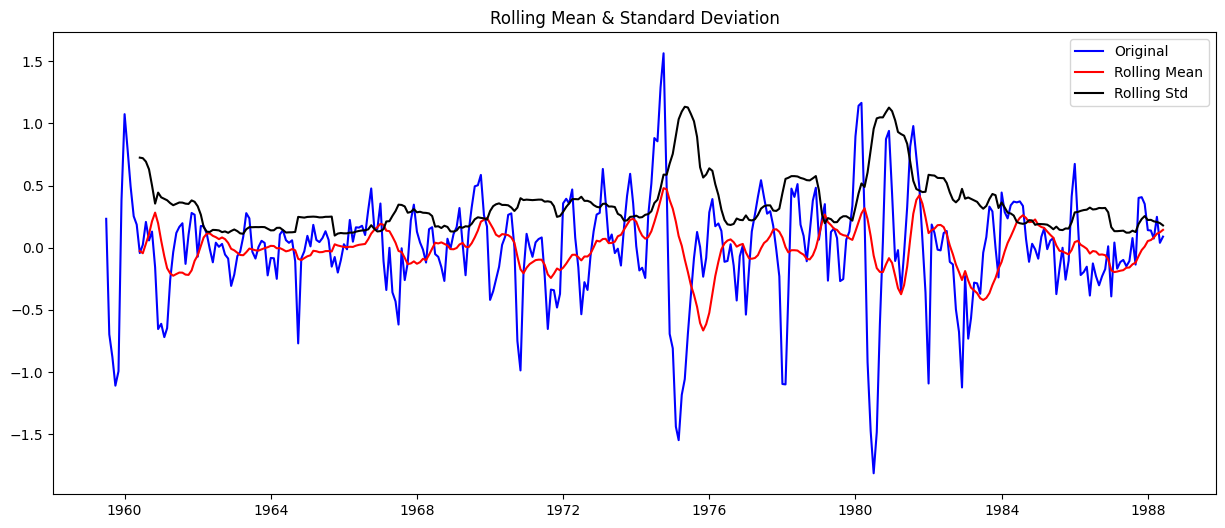

Results of Dickey-Fuller Test:
Test Statistic                -7.485564e+00
p-value                        4.649097e-11
#Lags Used                     5.000000e+00
Number of Observations Used    3.420000e+02
Critical Value (1%)           -3.449616e+00
Critical Value (5%)           -2.870028e+00
Critical Value (10%)          -2.571292e+00
dtype: float64
YES


'YES'

In [15]:
ts_r = residual
ts_r.dropna(inplace=True)
test_stationarity(ts_r)

In [ ]:
# вывод: разложили ряд на тренд,
# сезональность и остаток.
# На примере временного ряда training видим, что тренд
# не обладает стационарностью, а сезональность и остаток - обладают

# 3.

In [ ]:
# Функция для поиска коэффициента интегрированности ряда

In [16]:
def intK(timeseries):
    s = test_stationarity(timeseries)
    i = 0
    err = 1000
    while s == 'NO' and err:
        i += 1
        timeseries = timeseries.diff(periods=1).dropna()
        s = test_stationarity(timeseries)
        err -= 1
    if not err:
        return -1
    else:
        return i

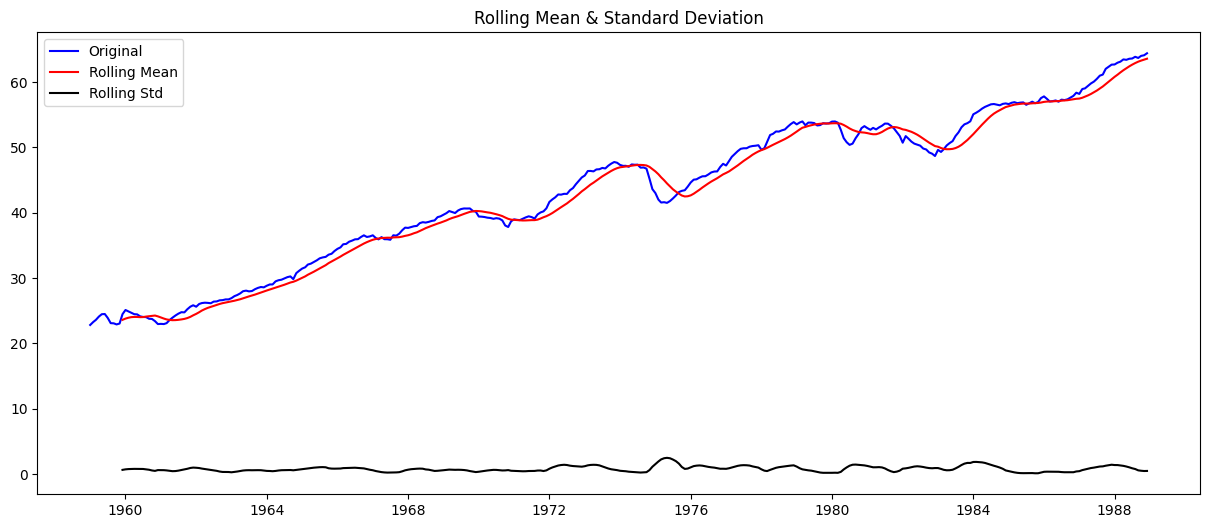

Results of Dickey-Fuller Test:
Test Statistic                  -0.253391
p-value                          0.931851
#Lags Used                       5.000000
Number of Observations Used    354.000000
Critical Value (1%)             -3.448958
Critical Value (5%)             -2.869739
Critical Value (10%)            -2.571138
dtype: float64
NO


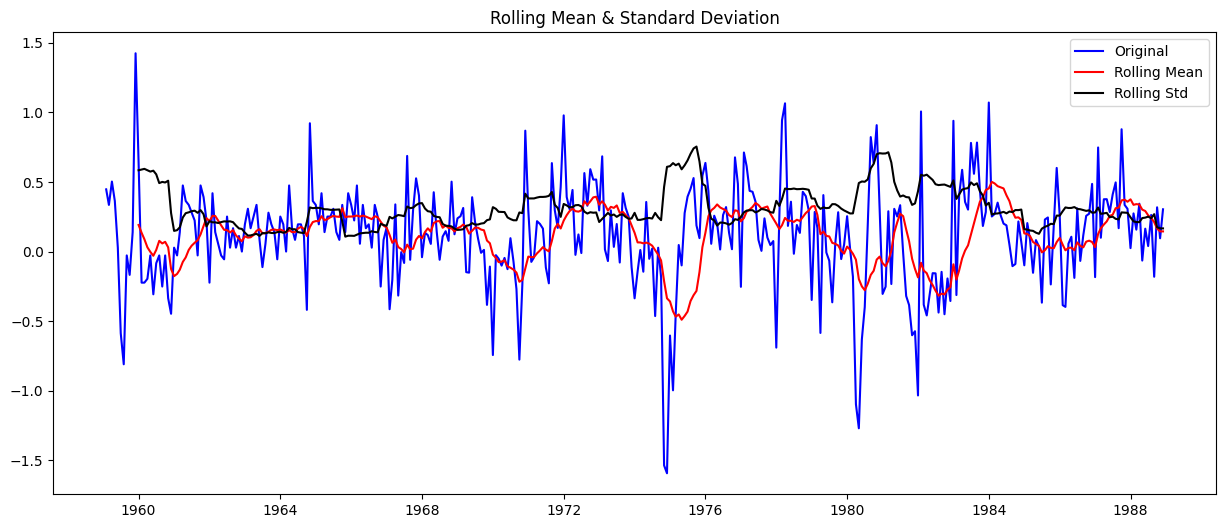

Results of Dickey-Fuller Test:
Test Statistic                -7.367311e+00
p-value                        9.164150e-11
#Lags Used                     4.000000e+00
Number of Observations Used    3.540000e+02
Critical Value (1%)           -3.448958e+00
Critical Value (5%)           -2.869739e+00
Critical Value (10%)          -2.571138e+00
dtype: float64
YES
1


In [17]:
k = intK(ts)
print(k)

In [ ]:
# Логарифмируем ряд

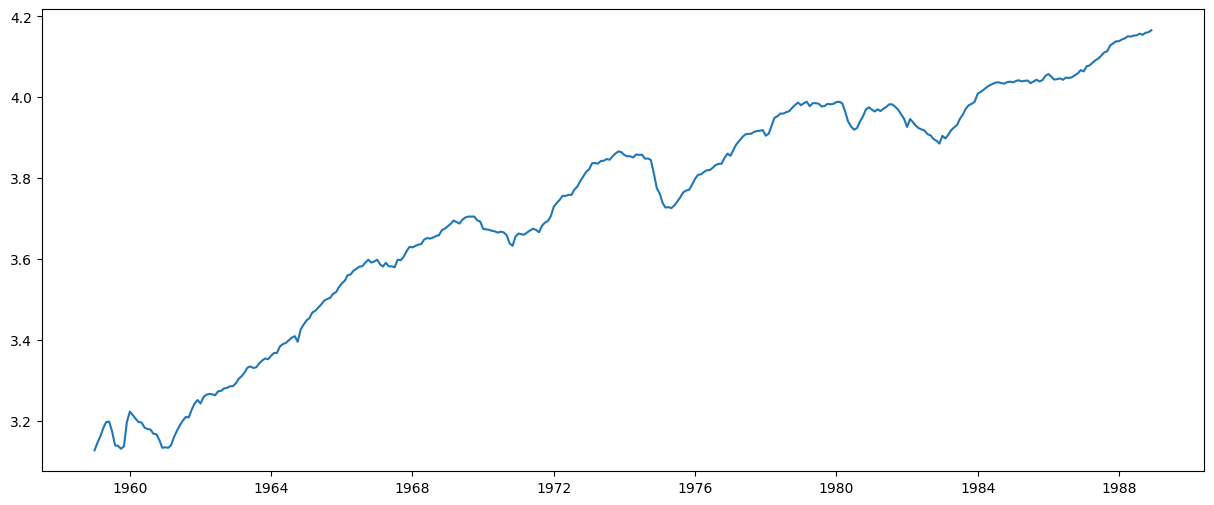

In [18]:
ts_log = np.log(ts)
plt.plot(ts_log)

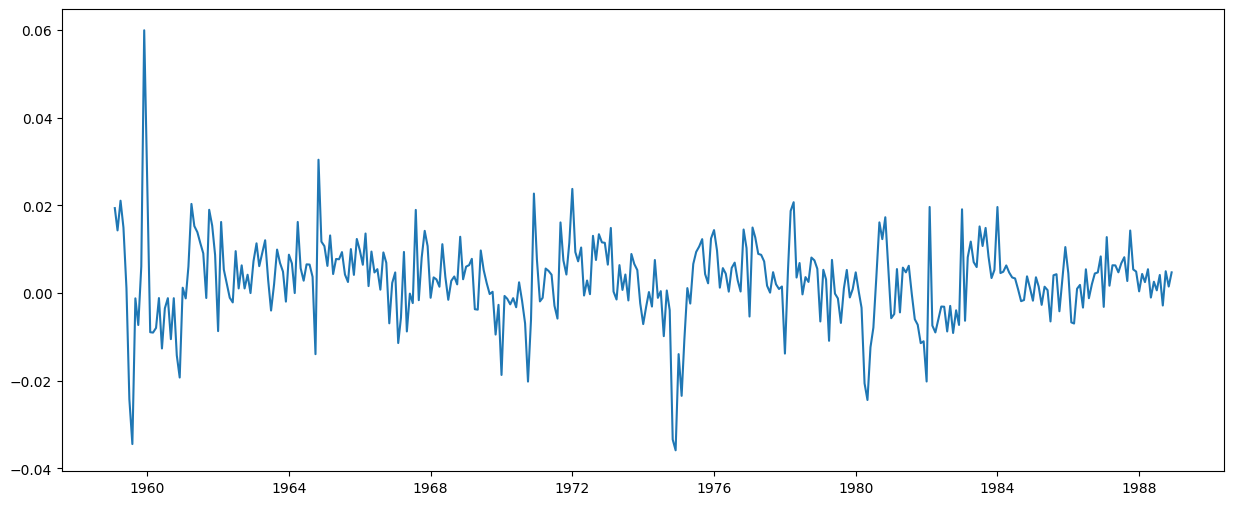

In [19]:
ts_log_diff = ts_log - ts_log.shift()
plt.plot(ts_log_diff)

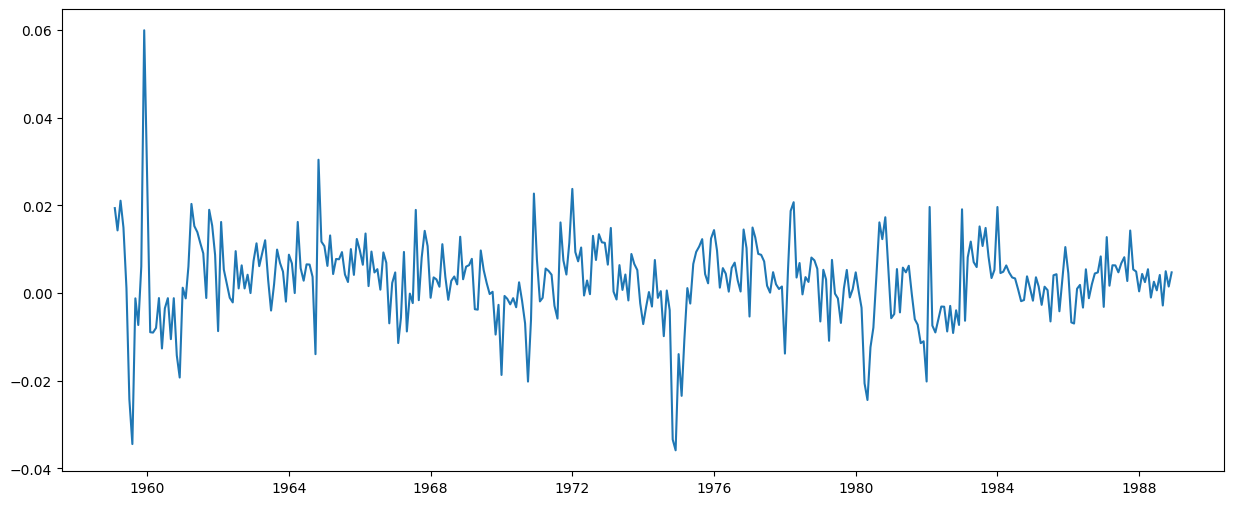

In [20]:
ts_log_diff.dropna(inplace=True)
plt.plot(ts_log_diff)

In [ ]:
# Подбираем нужные параметры с помощью функции автокорреляции
# и функции частичной автокорреляции

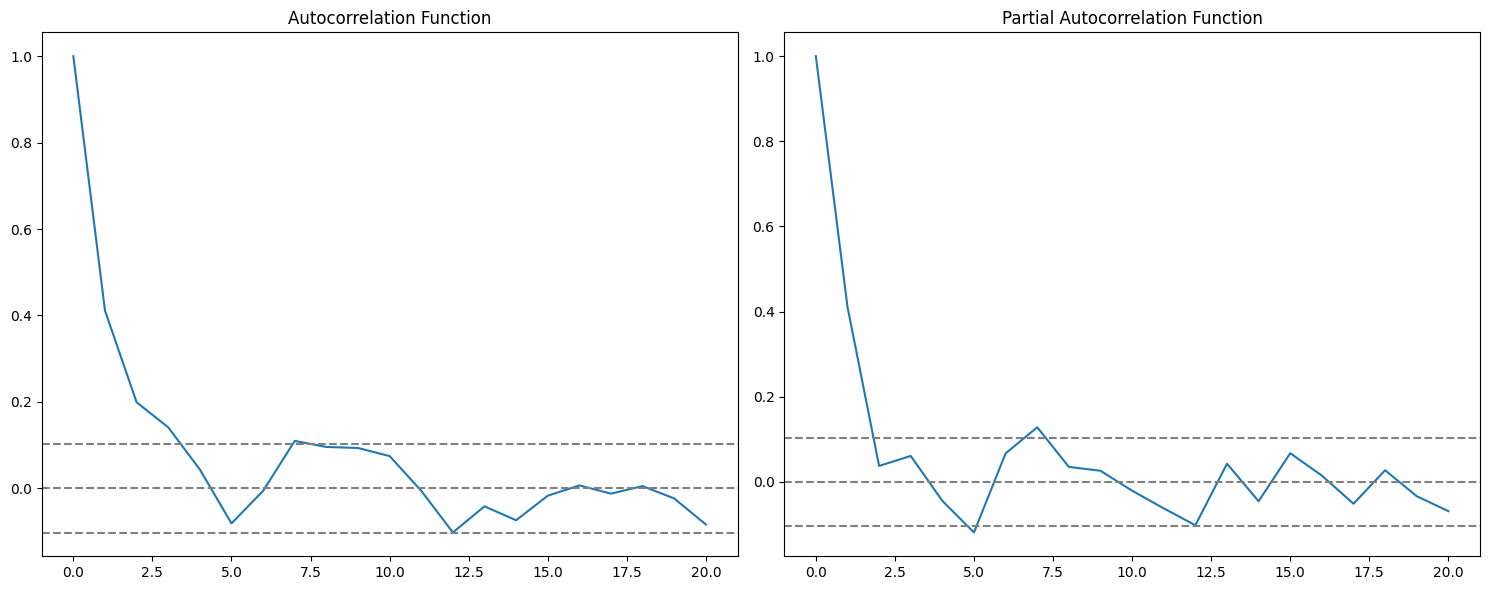

In [21]:
lag_acf = acf(ts_log_diff, nlags=20)
lag_pacf = pacf(ts_log_diff, nlags=20, method='ols')

# Plot ACF:
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96 / np.sqrt(len(ts_log_diff)), linestyle='--', color='gray')
plt.axhline(y=1.96 / np.sqrt(len(ts_log_diff)), linestyle='--', color='gray')
plt.title('Autocorrelation Function')

# Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96 / np.sqrt(len(ts_log_diff)), linestyle='--', color='gray')
plt.axhline(y=1.96 / np.sqrt(len(ts_log_diff)), linestyle='--', color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

q = int(lag_acf[0])
p = int(lag_pacf[0])

In [ ]:
# Применяем модель ARIMA

In [ ]:
model = ARIMA(ts_log, order=(p, k, q))
results_ARIMA = model.fit()
plt.plot(ts_log_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f' % sum((results_ARIMA.fittedvalues - ts_log_diff) ** 2))

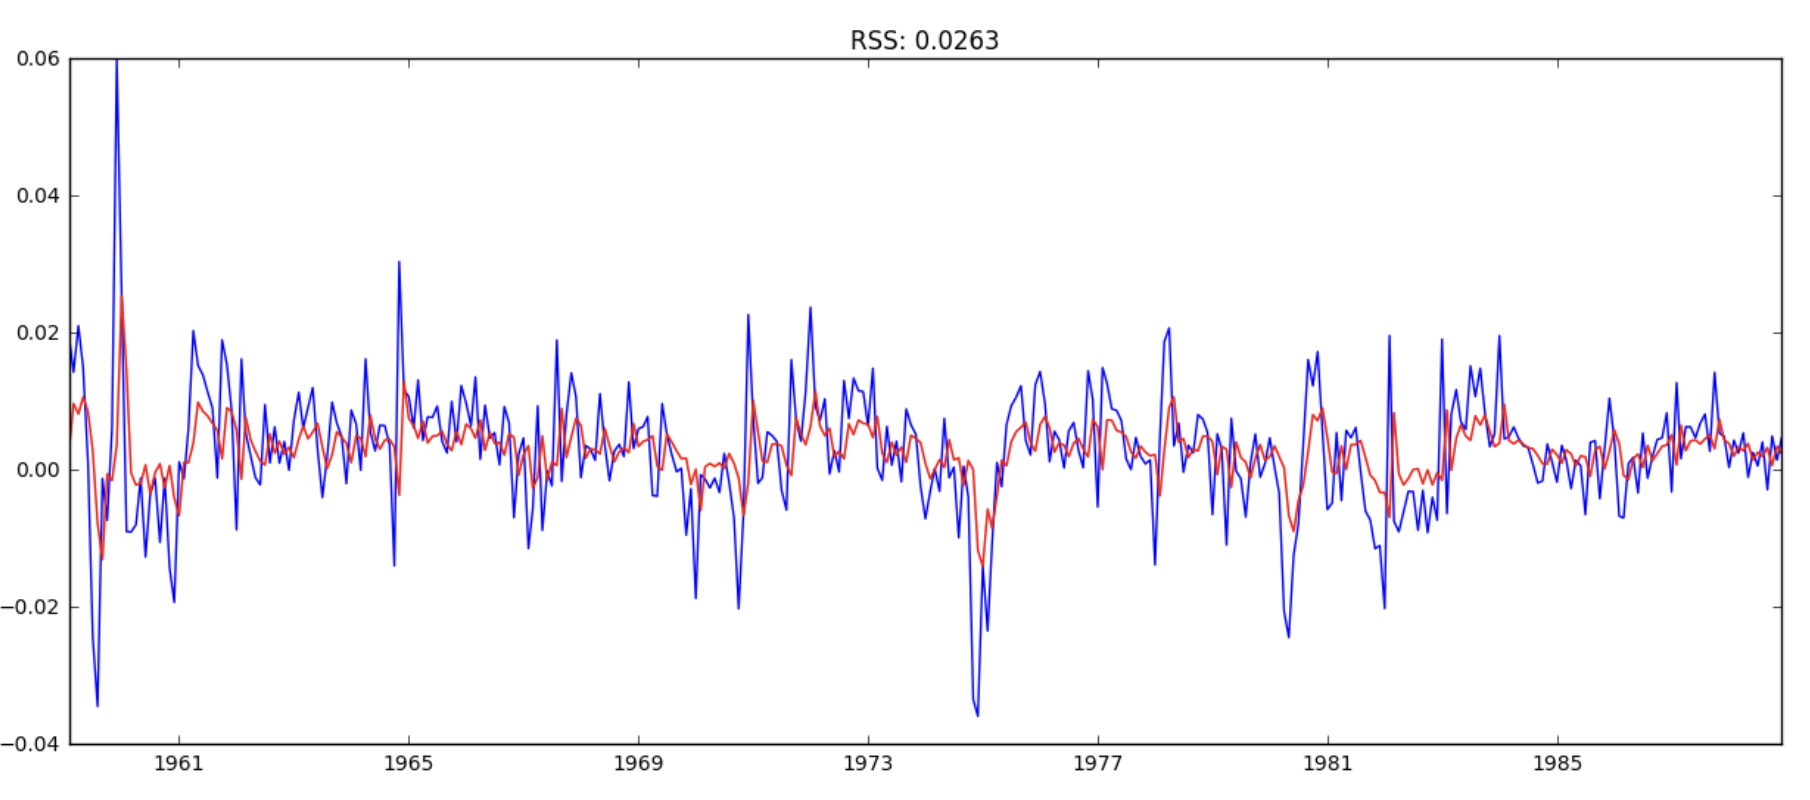

### Convert to original scale:

In [23]:
def convert_to_orig_scale(values):
    predictions_ARIMA_diff = pd.Series(values, copy=True)
    predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
    predictions_ARIMA_log = pd.Series(ts_log.iloc[0], index=ts_log.index)
    diff_cumsum = predictions_ARIMA_diff_cumsum
    predictions_ARIMA_log = predictions_ARIMA_log.add(diff_cumsum,
                                                      fill_value=0)
    predictions_ARIMA_log.head()
    predictions_ARIMA = np.exp(predictions_ARIMA_log)
    return predictions_ARIMA

In [ ]:
predictions = convert_to_orig_scale(results_ARIMA.fittedvalues)
plt.plot(ts)
plt.plot(predictions)
plt.title('R2 Score: %.4f' % r2_score(predictions, ts))

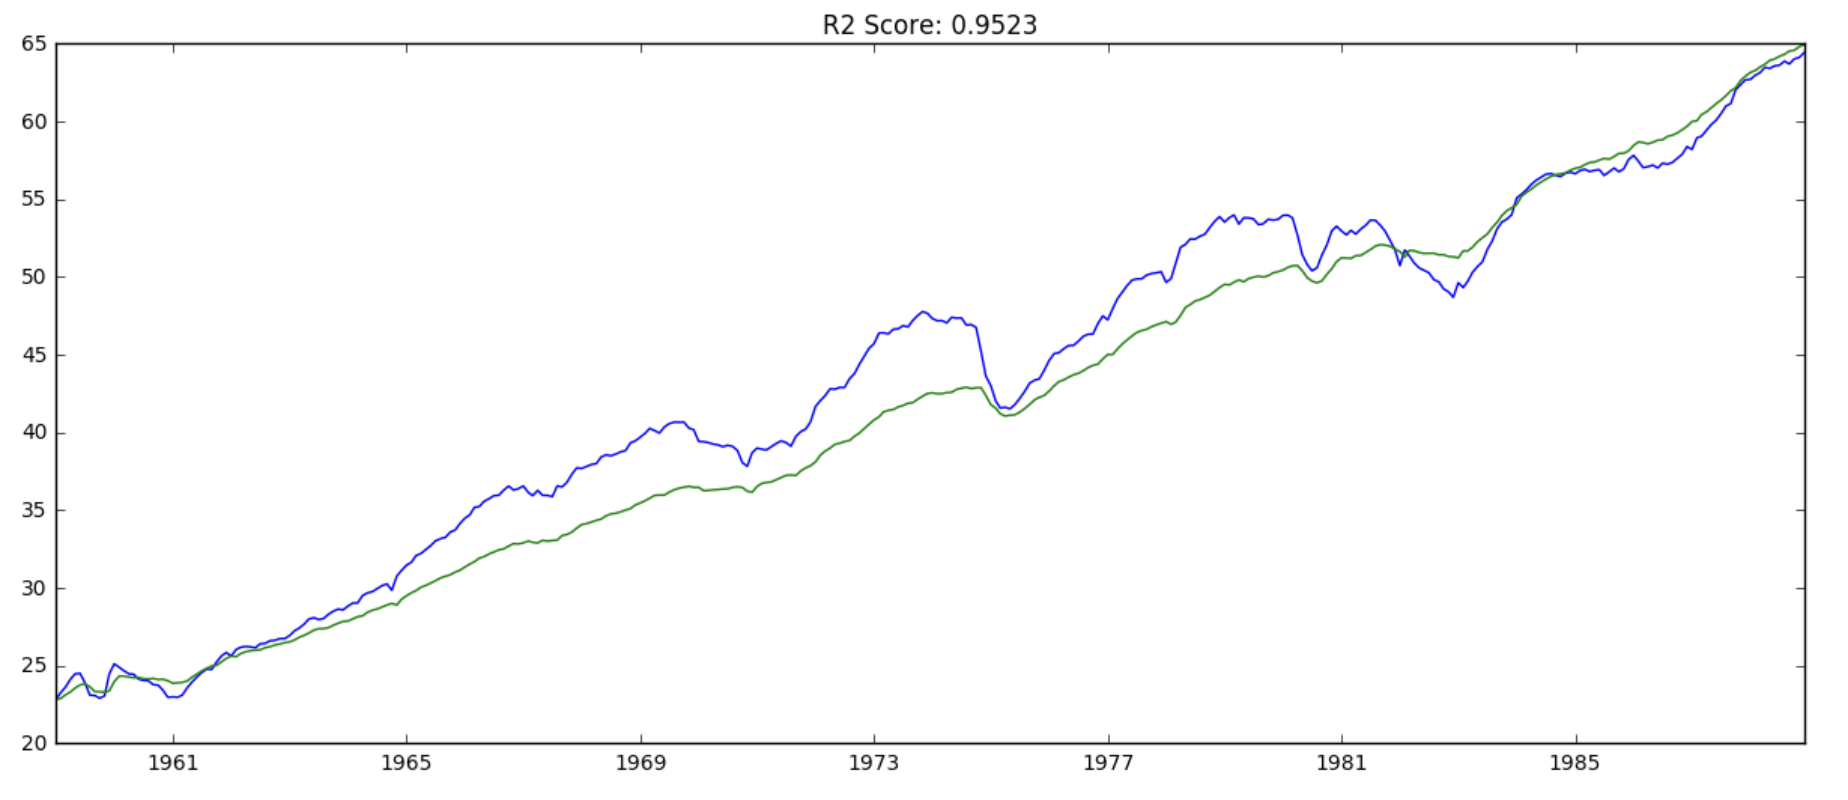

In [25]:
predict = results_ARIMA.predict(start='1959-02-01', end='1993-12-01')

### Тестовая выборка

In [26]:
ts = data2['Value']
ts_log = np.log(ts)

In [27]:
predict_log = results_ARIMA.predict(start='1988-12-01', end='1993-12-01')

In [ ]:
predictions = convert_to_orig_scale(predict_log)['1989-01-01':]
plt.plot(ts)
plt.plot(predictions)
plt.title('R2 Score: %.4f' % r2_score(predictions, ts))

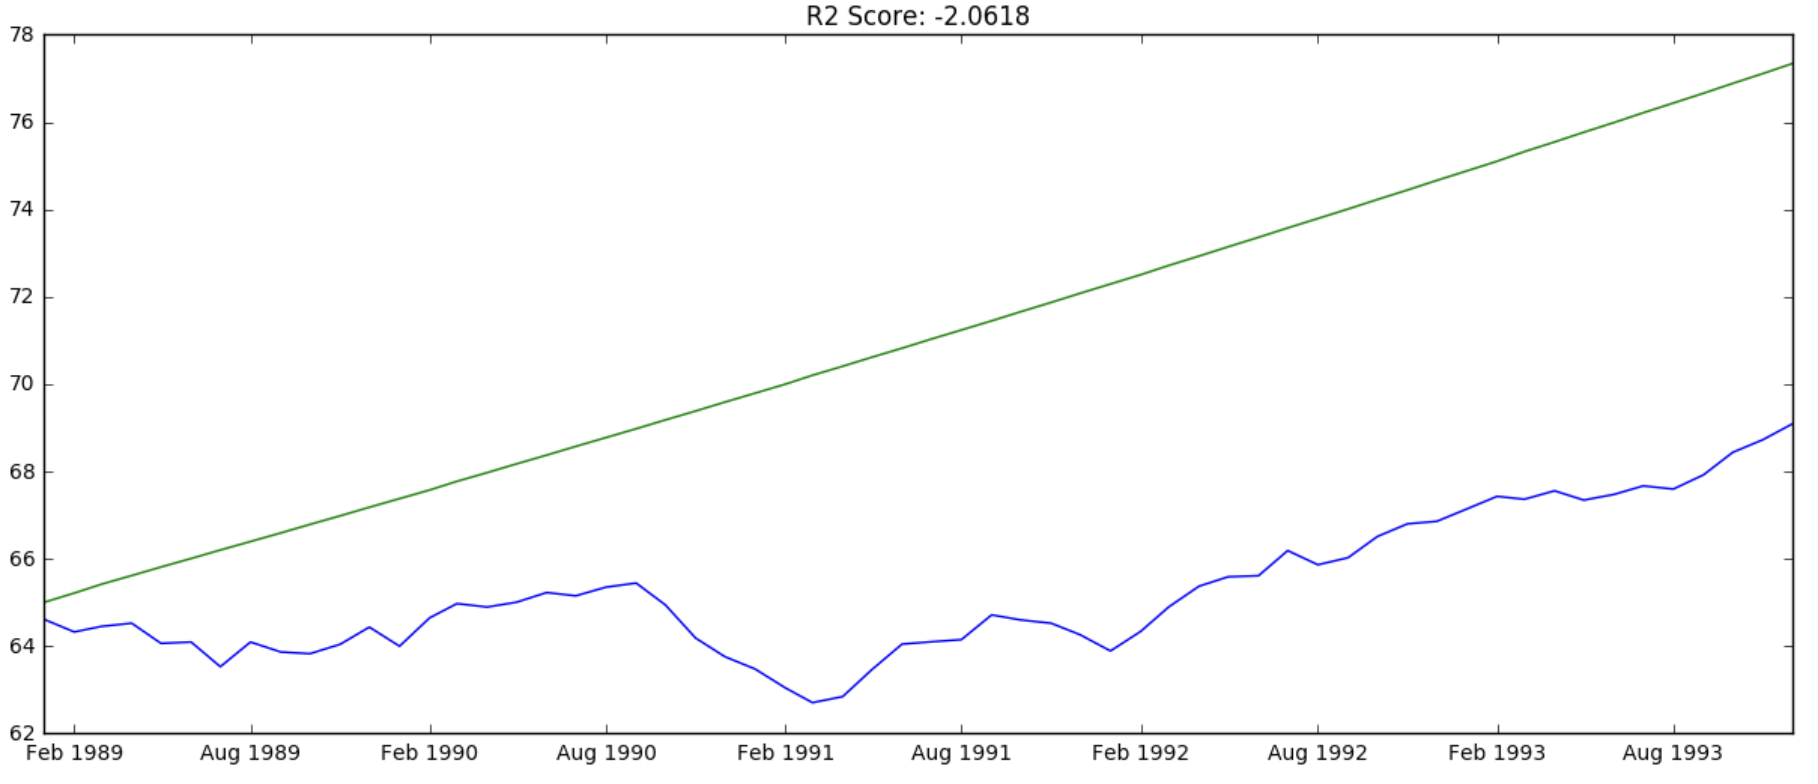

In [ ]:
# вывод: для ряда training коэффициент интегрированности равен 1.
# Логарифмируем ряд для увеличения точности,
# применяем к нему модель ARIMA, r2 score = 0.9523.